In [139]:

from __future__ import print_function
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, MaxPooling2D, Conv2D, Flatten
from keras.layers import Conv2DTranspose, LeakyReLU
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers

import numpy as np
from tqdm import tqdm
import cv2
import math

from keras.utils. generic_utils import Progbar

In [140]:
### combine images for visualization
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(math.sqrt(num))
    height = int(math.ceil(float(num)/width))
    shape = generated_images.shape[1:4]
    image = np.zeros((height*shape[0], width*shape[1], shape[2]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1],:] = img[:, :, :]
    return image

### generator model define
def generator_model(z_dim = 10, imgsize = 256, channels = 1): 
    col = int(imgsize / 4)
    inputs = Input((z_dim, ))
    fc1 = Dense(input_dim=z_dim, units=128*col*col)(inputs)
    fc1 = BatchNormalization()(fc1)
    fc1 = LeakyReLU(0.2)(fc1)

    fc2 = Reshape((col, col, 128), input_shape=(128*col*col,))(fc1)
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(fc2)
    conv1 = Conv2D(64, (3,3), padding='same')(up1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    up2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv1)
    conv2 = Conv2D(channels, (5, 5), padding='same')(up2)
    outputs = Activation('tanh')(conv2)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

def discriminator_model(img_size = 256, channels = 1):
    inputs = Input((img_size, img_size, channels))

    conv1 = Conv2D(64, (5,5), padding='same')(inputs)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(128, (5,5), padding='same')(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    fc1 = Flatten()(pool2)
    fc1 = Dense(1)(fc1)
    outputs = Activation('sigmoid')(fc1)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

### d_on_g model for training generator
def generator_containing_discriminator(g, d, z_dim = 10):
    d.trainable = False

    ganInput = Input(shape=(z_dim, ))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)

    return gan

def load_model():
    d = discriminator_model()
    g = generator_model()
    d_optim = RMSprop()
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='binary_crossentropy', optimizer=g_optim)
    d.compile(loss='binary_crossentropy', optimizer=d_optim)
    d.load_weights('./weights/discriminator.h5')
    g.load_weights('./weights/generator.h5')
    return g, d

In [141]:
### train generator and discriminator
def train(BATCH_SIZE, X_train, z_dim=10):
    
    ### model define
    d = discriminator_model()
    g = generator_model()
    d_on_g = generator_containing_discriminator(g, d)
    d_optim = RMSprop(lr=0.0004)
    g_optim = RMSprop(lr=0.0002)
    g.compile(loss='mse', optimizer=g_optim)
    d_on_g.compile(loss='mse', optimizer=g_optim)
    d.trainable = True
    d.compile(loss='mse', optimizer=d_optim)
    

    for epoch in range(10):
        print ("Epoch is", epoch)
        n_iter = int(X_train.shape[0]/BATCH_SIZE)
        progress_bar = Progbar(target=n_iter)
        
        for index in range(n_iter):
            # create random noise -> U(0,1) 10 latent vectors
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, z_dim))
            # noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 256))

            # load real data & generate fake data
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            
            # visualize training results
            if index % 20 == 0:
                image = combine_images(generated_images)
                image = image*127.5+127.5
                cv2.imwrite('./result/'+str(epoch)+"_"+str(index)+".png", image)

            # attach label for training discriminator
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            
            # training discriminator
            d_loss = d.train_on_batch(X, y)

            # training generator
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True

            progress_bar.update(index, values=[('g',g_loss), ('d',d_loss)])
        print ('')

        # save weights for each epoch
        g.save_weights('weights/generator.h5', True)
        d.save_weights('weights/discriminator.h5', True)
    return d, g


In [142]:
### generate images
def generate(BATCH_SIZE, z_dim=10):
    g = generator_model()
    g.load_weights('weights/generator.h5')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, z_dim))
    # noise = np.random.uniform(0, 1, (BATCH_SIZE, 256))
    generated_images = g.predict(noise)
    return generated_images

### anomaly loss function 
def sum_of_residual(y_true, y_pred):
    return K.sum(K.abs(K.cast(y_true, dtype='float32') - K.cast(y_pred, dtype='float32')))

### discriminator intermediate layer feautre extraction
def feature_extractor(d=None):
    if d is None:
        d = discriminator_model()
        d.load_weights('weights/discriminator.h5') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-7].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='rmsprop')
    return intermidiate_model

### anomaly detection model define
def anomaly_detector(g=None, d=None, z_dim=10):
    if g is None:
        g = generator_model()
        g.load_weights('weights/generator.h5')
    intermidiate_model = feature_extractor(d)
    intermidiate_model.trainable = False
    g = Model(inputs=g.layers[1].input, outputs=g.layers[-1].output)
    g.trainable = False
    # Input layer cann't be trained. Add new layer as same size & same distribution
    aInput = Input(shape=(z_dim,))
    gInput = Dense((10), trainable=True)(aInput)
    gInput = Activation('sigmoid')(gInput)
    
    # G & D feature
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.90, 0.10], optimizer='rmsprop')
    
    # batchnorm learning phase fixed (test) : make non trainable
    K.set_learning_phase(0)
    
    return model


In [143]:
### anomaly detection
def compute_anomaly_score(model, x, iterations=500, d=None, z_dim=10):
    z = np.random.uniform(0, 1, size=(1, z_dim))
    
    intermidiate_model = feature_extractor(d)
    d_x = intermidiate_model.predict(x)

    # learning for changing latent
    loss = model.fit(z, [x, d_x], batch_size=1, epochs=iterations, verbose=0)
    similar_data, _ = model.predict(z)
    
    loss = loss.history['loss'][-1]
    
    return loss, similar_data

In [73]:
pip install PyQt5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
from __future__ import print_function

import matplotlib
matplotlib.use('Agg')
# import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import mnist
import argparse

import argparse
# import anogan
import h5py

In [147]:
os.chdir('/content/drive/MyDrive/DSCI 441 - Anomaly detection in images')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

if not os.path.isdir("/content/drive/MyDrive/DSCI 441 - Anomaly detection in images"):
	os.mkdir("/content/drive/MyDrive/DSCI 441 - Anomaly detection in images")

In [76]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--img_idx', type=int, default=14)
# parser.add_argument('--label_idx', type=int, default=7)
# parser.add_argument('--mode', type=str, default='test', help='train, test')
# args = parser.parse_args()
# parser.parse_args()

In [ ]:
from PIL import Image

# Define path to image directory in Google Drive
norm_img_path = '/content/drive/MyDrive/Classifier_input_org_img/normal'
ptb_img_path = '/content/drive/MyDrive/Classifier_input_org_img/ptb'

# Load train image data from directory
data = []
for file in os.listdir(norm_img_path):
    img = Image.open(os.path.join(norm_img_path, file)).convert('L')
    img = img.resize((256, 256))
    data.append(np.array(img).reshape(256, 256, 1))

X_train = np.array(data)

# Load test image data from directory
data = []
for file in os.listdir(ptb_img_path):
    img = Image.open(os.path.join(ptb_img_path, file)).convert('L')
    img = img.resize((256, 256))
    data.append(np.array(img).reshape(256, 256, 1))

X_test = np.array(data)


In [144]:
print("The shape of train set", X_train.shape)
print("The shape of test set", X_test.shape)
X_test_original = X_test.copy()

The shape of train set (326, 256, 256, 1)
The shape of test set (302, 256, 256, 1)


(256, 256, 1)


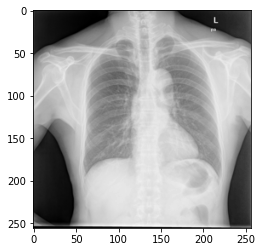

In [96]:
image = X_train[0]
print(image.shape)
first_img = np.reshape(image, (256, 256))

# Plot image
plt.imshow(first_img, cmap='gray')
plt.show()

In [79]:
# from PIL import Image
# img = Image.open(os.path.join('/content/drive/MyDrive/Classifier_input_org_img/normal/', 'CHNCXR_0001_0.png')).convert('L')
# img = img.resize((512, 512))
# plt.imshow(img, cmap='gray')
# plt.show()

In [80]:
# ### 0. prepare data
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train = (X_train.astype(np.float32) - 127.5) / 127.5
# X_test = (X_test.astype(np.float32) - 127.5) / 127.5

# X_train = X_train[:,:,:,None]
# X_test = X_test[:,:,:,None]

# X_test_original = X_test.copy()

# # X_train = X_train[y_train==1]
# # X_test = X_test[y_test==1]
# print ('train shape:', X_train.shape)
# print ('test shape:', X_test.shape)

In [145]:
### 1. train generator & discriminator
Model_d, Model_g = train(64, X_train)

Model: "model_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_76 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_105 (Conv2D)         (None, 256, 256, 64)      1664      
                                                                 
 leaky_re_lu_84 (LeakyReLU)  (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 128, 128, 128)     204928    
                                                                 
 leaky_re_lu_85 (LeakyReLU)  (None, 128, 128, 128)     0         
                                                          

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch is 0
4/5 [=======================>......] - ETA: 2:54 - g: 0.0997 - d: 0.1035
Epoch is 1
4/5 [=======================>......] - ETA: 2:55 - g: 0.3652 - d: 0.2596
Epoch is 2
4/5 [=======================>......] - ETA: 2:54 - g: 0.0000e+00 - d: 0.2972
Epoch is 3
4/5 [=======================>......] - ETA: 2:56 - g: 0.0000e+00 - d: 0.0037
Epoch is 4
4/5 [=======================>......] - ETA: 2:54 - g: 0.0000e+00 - d: 0.0012
Epoch is 5
4/5 [=======================>......] - ETA: 2:55 - g: 0.0000e+00 - d: 6.6740e-04
Epoch is 6
4/5 [=======================>......] - ETA: 2:56 - g: 0.0000e+00 - d: 4.1655e-04
Epoch is 7
4/5 [=======================>......] - ETA: 2:55 - g: 0.0000e+00 - d: 2.7891e-04
Epoch is 8
4/5 [=======================>......] - ETA: 2:55 - g: 0.0000e+00 - d: 1.9543e-04
Epoch is 9
4/5 [=======================>......] - ETA: 2:55 - g: 0.0000e+00 - d: 1.3901e-04


In [148]:
### 2. test generator
generated_img = generate(25)
img = combine_images(generated_img)
img = (img*127.5)+127.5
img = img.astype(np.uint8)
img = cv2.resize(img, None, fx=4, fy=4, interpolation=cv2.INTER_NEAREST)

Model: "model_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_80 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_66 (Dense)            (None, 524288)            5767168   
                                                                 
 batch_normalization_51 (Bat  (None, 524288)           2097152   
 chNormalization)                                                
                                                                 
 leaky_re_lu_88 (LeakyReLU)  (None, 524288)            0         
                                                                 
 reshape_27 (Reshape)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 128, 128, 64)     32832     
 Transpose)                                               

In [149]:
def anomaly_detection(test_img, img_size=256, g=None, d=None):
    model = anomaly_detector(g=g, d=d)
    ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, img_size, img_size, 1), iterations=500, d=d)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(img_size,img_size,1) - similar_img.reshape(img_size,img_size,1)
    np_residual = (np_residual + 2)/4

    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(img_size,img_size,1)*127.5+127.5).astype(np.uint8)
    similar_x = (similar_img.reshape(img_size,img_size,1)*127.5+127.5).astype(np.uint8)

    original_x_color = cv2.cvtColor(original_x, cv2.COLOR_GRAY2BGR)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x_color, 0.3, residual_color, 0.7, 0.)

    return ano_score, original_x, similar_x, show

In [53]:
img_idx = int(input("Enter the value of img_idx: "))

label_idx = int(input("Enter the value of label_idx: "))

mode = str(input("Enter the value of mode (train/test): "))

Enter the value of img_idx: 15
Enter the value of label_idx: 1
Enter the value of mode (train/test): train


(256, 256, 1)


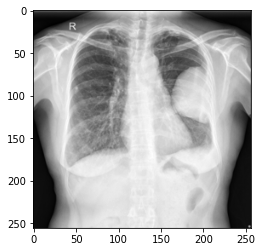

In [151]:
image = X_test_original[0]
print(image.shape)
first_img = np.reshape(image, (256, 256))

# Plot image
plt.imshow(first_img, cmap='gray')
plt.show()

Model: "model_112"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_89 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_75 (Dense)            (None, 524288)            5767168   
                                                                 
 batch_normalization_57 (Bat  (None, 524288)           2097152   
 chNormalization)                                                
                                                                 
 leaky_re_lu_99 (LeakyReLU)  (None, 524288)            0         
                                                                 
 reshape_30 (Reshape)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_56 (Conv2D  (None, 128, 128, 64)     32832     
 Transpose)                                              

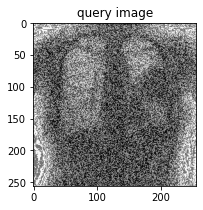

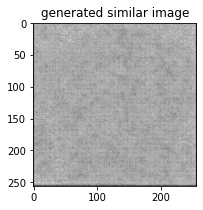

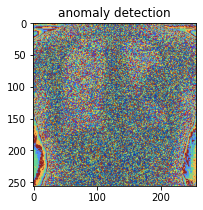

In [154]:
### compute anomaly score - sample from strange image
# img_idx = img_idx
# label_idx = label_idx
test_img = X_test_original[0]
# test_img = np.random.uniform(-1,1, (28,28,1))

start = cv2.getTickCount()
score, qurey, pred, diff = anomaly_detection(test_img)
time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
# print ('%d label, %d : done'%(label_idx, img_idx), '%.2f'%score, '%.2fms'%time)
# cv2.imwrite('./qurey.png', qurey)
# cv2.imwrite('./pred.png', pred)
# cv2.imwrite('./diff.png', diff)

## matplot view
plt.figure(1, figsize=(3, 3))
plt.title('query image')
plt.imshow(qurey.reshape(256,256), cmap=plt.cm.gray)

print("anomaly score : ", score)
plt.figure(2, figsize=(3, 3))
plt.title('generated similar image')
plt.imshow(pred.reshape(256,256), cmap=plt.cm.gray)

plt.figure(3, figsize=(3, 3))
plt.title('anomaly detection')
plt.imshow(cv2.cvtColor(diff,cv2.COLOR_BGR2RGB))
plt.show()

In [1]:
### 4. tsne feature view

### t-SNE embedding 
### generating anomaly image for test (radom noise image)

from sklearn.manifold import TSNE

random_image = np.random.uniform(0, 1, (100, 256, 256, 1))
print("random noise image")
plt.figure(4, figsize=(2, 2))
plt.title('random noise image')
plt.imshow(random_image[0].reshape(256,256), cmap=plt.cm.gray)

# intermidieate output of discriminator
model = feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(X_test_original[:300], verbose=1)
feature_map_of_minist_1 = model.predict(X_test[:100], verbose=1)

# t-SNE for visulization
output = np.concatenate((feature_map_of_random, feature_map_of_minist, feature_map_of_minist_1))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*100+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.figure(5)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:100,0], X_embedded[:100,1], label='random noise(anomaly)')
plt.scatter(X_embedded[100:400,0], X_embedded[100:400,1], label='mnist(anomaly)')
plt.scatter(X_embedded[400:,0], X_embedded[400:,1], label='mnist(normal)')
plt.legend()
plt.show()

NameError: ignored